## 2. U-Net based Approach

Since the images only constituted of a main object, we thought of improving predictions by segmentation.

There were several predictions that even though with the obvious features gave a wrong output, to overcome this limitation of our previous models, we tried training U-Net on our data to give segmentations from which bounding boxes can be extracted.

But a major hurdle was that the training data just had bounding boxes and not foreground mask on the object. We tried rectangular masks by just using the bounding box coordinates but it didn't work out so well.

So we improvised and used OpenCV to extract foreground mask from object through multiple filters. (An obvious way would have been using other deep learning models but that would again violate the competition rules)

Let's start by importing the necessary libraries and defining global variables.

In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
%matplotlib inline
import glob
import math

from keras.callbacks import LearningRateScheduler
from keras.engine.input_layer import Input
from keras.layers import Lambda, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from keras import Model
from scipy.ndimage.measurements import label
from keras.optimizers import Adam
from keras.backend import epsilon
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

import time
from sklearn.metrics import jaccard_similarity_score
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
import pandas as pd
import os
import cv2
from PIL import Image, ImageDraw, ImageEnhance
from keras.utils import Sequence
dir_label = ['images']
BATCH_SIZE = 4

##### Image size
img_rows = 480
img_cols = 640

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

Using TensorFlow backend.


Loading training and testing data for segmentation.

In [3]:
### Make data frame in Pandas
train_df = pd.read_csv('training_set.csv')
train_df['File_Path'] =  'images/'+train_df['image_name']
train_df.columns = ['Frame', 'xmin', 'xmax', 'ymin','ymax', 'File_Path']
train_df = train_df[['File_Path','Frame','ymin','xmin','ymax','xmax']]
train_df.head()

,File_Path,Frame,ymin,xmin,ymax,xmax
0,images/JPEG_20160517_140621_1000651031832.png,JPEG_20160517_140621_1000651031832.png,83,78,422,446
1,images/1473231510890DeeplearnS11456.png,1473231510890DeeplearnS11456.png,146,73,351,567
2,images/1476881557883Untitled1.png,1476881557883Untitled1.png,124,13,362,561
3,images/1474264827890cobalt-beyond-the-sea-maxi...,1474264827890cobalt-beyond-the-sea-maxi-dress3...,140,0,330,640
4,images/JPEG_20160711_113321_1000235741992.png,JPEG_20160711_113321_1000235741992.png,65,217,465,442


In [4]:
### Make data frame in Pandas
test_df = pd.read_csv('validation.csv')
test_df['File_Path'] =  'images/'+test_df['image_name']
test_df.columns = ['Frame', 'xmin', 'xmax', 'ymin','ymax', 'File_Path']
test_df = test_df[['File_Path','Frame','ymin','xmin','ymax','xmax']]
test_df.head()

,File_Path,Frame,ymin,xmin,ymax,xmax
0,images/1471617584458DSC_0333.png,1471617584458DSC_0333.png,41,28,450,609
1,images/1467976067838DSC_0503.png,1467976067838DSC_0503.png,159,48,267,561
2,images/JPEG_20160704_145252_1000756879461.png,JPEG_20160704_145252_1000756879461.png,54,179,406,501
3,images/1475059990785DSC02424.png,1475059990785DSC02424.png,106,30,386,625
4,images/147771738670920161028_170650.png,147771738670920161028_170650.png,80,87,480,640


In [5]:
### Make data frame in Pandas
testing_df = pd.read_csv('test.csv')
testing_df['File_Path'] =  'images/'+testing_df['image_name']
testing_df.columns = ['Frame', 'xmin', 'xmax', 'ymin','ymax', 'File_Path']
testing_df = testing_df[['File_Path','Frame','ymin','xmin','ymax','xmax']]
testing_df.head()

,File_Path,Frame,ymin,xmin,ymax,xmax
0,images/1467891670691DSC_0582.png,1467891670691DSC_0582.png,NaN,NaN,NaN,NaN
1,images/1475151786691DSC00560.png,1475151786691DSC00560.png,NaN,NaN,NaN,NaN
2,images/1480334114405_R2A3620.png,1480334114405_R2A3620.png,NaN,NaN,NaN,NaN
3,images/JPEG_20160712_161047_1000606860114.png,JPEG_20160712_161047_1000606860114.png,NaN,NaN,NaN,NaN
4,images/JPEG_20160403_174522_-1137349501.png,JPEG_20160403_174522_-1137349501.png,NaN,NaN,NaN,NaN


### Preparation of Foreground Mask

For every image in the dataset, the following algorithm was followed to extract a binary foreground mask:
* *Histogram Equalization* for enhanced distinguishment of objects with similar colour as of background 
* *Otsu's adaptive thresholding* was applied to the grayscale image for a rough contrast-based seperation of foreground 
* *Box Filtering* The mask hence obtained was filtered only for the coordinates annotated as in the dataset (i.e. for the object area)
* *Mask Closing* Closing operation with a kernel of (50x50) with 3 iterations was performed for the mask to fill the voids if any, since objects in the dataset are mostly continuous
* *Mask seperation into background/foreground* Two more masks were created hence- *Mask 1* and *Mask 2*. *Mask 1* consisted of pixels will all *ones* (foreground) as 255, and *Mask 2* consisted of pixels with all *zeros* (background) as 255.
* These *Mask 1* and *Mask 2* were then eroded seperately, so as to create a significant discontinuity between the  Masks. These Masks were then used as Markers for further process
* *Watershed Segmentation* The binary blobs obtained hence were used as markers for watershed segmentation on the dataset image.

The final result hence obtained was an approximate mask of foreground object in the image, which was used for training U-Net.

This function takes as the input the image and the corresponding bounding box and outputs the binary mask representing the segmented object

In [6]:
def get_mask_seg(img,bb_boxes_f, size=(640,480)):
    
    for i in range(len(bb_boxes_f)):

        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        cv2.equalizeHist(gray)

        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        fg = cv2.erode(thresh,None,iterations = 2)
        bgt = cv2.dilate(thresh,None,iterations = 3)
        ret,bg = cv2.threshold(bgt,1,128,1)
        marker = cv2.add(fg,bg)

        marker32 = np.int32(marker)
        cv2.watershed(img,marker32)
        m = cv2.convertScaleAbs(marker32)
        bb_box_i = [bb_boxes_f.iloc[i]['xmin'],bb_boxes_f.iloc[i]['ymin'],
                bb_boxes_f.iloc[i]['xmax'],bb_boxes_f.iloc[i]['ymax']]
        bb_box_i = np.array(bb_box_i, dtype='int')
        ret,thresh = cv2.threshold(m,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(100,100)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(100,100)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(100,100)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(150,150)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(100,100)))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT,(150,150)))

        res = cv2.bitwise_and(img,img,mask = thresh)    

        threshres = np.zeros( (len(img), len(img[0])) )
        threshres[ bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2] ] = thresh[ bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2] ]
        img_mask = np.reshape(threshres,(np.shape(threshres)[0],np.shape(threshres)[1],1))

    return img_mask

The following series of functions implement different data augmentation techniques, as listed below:
- Brightness
- Translations
- Streching

In [7]:

def brightness_augmentation(img):
    
    img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    img[:,:,2] = img[:,:,2]*0.25+np.random.uniform()
    img = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    return img

def trans_augmentation(img,bb_boxes_f,trans_range):
  
    bb_boxes_f = bb_boxes_f.copy(deep=True)

    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    rows,cols,channels = img.shape
    bb_boxes_f['xmin'] = (bb_boxes_f['xmin']+tr_x).clip(0,640)
    bb_boxes_f['xmax'] = (bb_boxes_f['xmax']+tr_x).clip(0,640)
    bb_boxes_f['ymin'] = (bb_boxes_f['ymin']+tr_y).clip(0,480)
    bb_boxes_f['ymax'] = (bb_boxes_f['ymax']+tr_y).clip(0,480)
    
    img_tr = cv2.warpAffine(img,Trans_M,(cols,rows))
    
    return img_tr,bb_boxes_f


def stretching_augmentation(img,bb_boxes_f,scale_range):
    
    bb_boxes_f = bb_boxes_f.copy(deep=True)
    
    tr_x1 = scale_range*np.random.uniform()
    tr_y1 = scale_range*np.random.uniform()
    p1 = (tr_x1,tr_y1)
    tr_x2 = scale_range*np.random.uniform()
    tr_y2 = scale_range*np.random.uniform()
    p2 = (img.shape[1]-tr_x2,tr_y1)

    p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
    p4 = (tr_x1,img.shape[0]-tr_y2)

    pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
    pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],
                   [0,img.shape[0]] ]
                   )

    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    img = np.array(img,dtype=np.uint8)
    
    bb_boxes_f['xmin'] = ((bb_boxes_f['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]).clip(0,640)
    bb_boxes_f['xmax'] = ((bb_boxes_f['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]).clip(0,640)
    bb_boxes_f['ymin'] = ((bb_boxes_f['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]).clip(0,480)
    bb_boxes_f['ymax'] = ((bb_boxes_f['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]).clip(0,480)
    
    return img,bb_boxes_f

A helper function to get an image's name and corrseponding bounding box using its index in the data frame.

In [8]:
def id2imgname(df,ind,size=(640,480),augmentation = False,trans_range = 20,scale_range=20):
    
    file_name = df['File_Path'][ind]
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,size)
    name_str = file_name.split('/')
    name_str = name_str[-1]

    bb_boxes = df[df['Frame'] == name_str].reset_index()
    img_size_post = np.shape(img)
    
    if augmentation == True:
        img,bb_boxes = trans_augmentation(img,bb_boxes,trans_range)
        img,bb_boxes = stretching_augmentation(img,bb_boxes,scale_range)
        img = brightness_augmentation(img)
        
    bb_boxes['xmin'] = np.round(bb_boxes['xmin']/img_size[1]*img_size_post[1]).clip(0)
    bb_boxes['xmax'] = np.round(bb_boxes['xmax']/img_size[1]*img_size_post[1]).clip(0)
    bb_boxes['ymin'] = np.round(bb_boxes['ymin']/img_size[0]*img_size_post[0]).clip(0)
    bb_boxes['ymax'] = np.round(bb_boxes['ymax']/img_size[0]*img_size_post[0]).clip(0)
    bb_boxes['Area'] = (bb_boxes['xmax']- bb_boxes['xmin'])*(bb_boxes['ymax']- bb_boxes['ymin']) 
        
    return name_str,img,bb_boxes

def plot_im_mask(im,im_mask):
    ### Function to plot image mask 
    
    im = np.array(im,dtype=np.uint8)
    im_mask = np.array(im_mask,dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

def plot_bbox(bb_boxes,ind_bb,color='r',linewidth=2):
    ### Plot bounding box
    
    bb_box_i = [bb_boxes.iloc[ind_bb]['xmin'],
                bb_boxes.iloc[ind_bb]['ymin'],
                bb_boxes.iloc[ind_bb]['xmax'],
                bb_boxes.iloc[ind_bb]['ymax']]
    plt.plot([bb_box_i[0],bb_box_i[2],bb_box_i[2],
                  bb_box_i[0],bb_box_i[0]],
             [bb_box_i[1],bb_box_i[1],bb_box_i[3],
                  bb_box_i[3],bb_box_i[1]],
             color,linewidth=linewidth)

def plot_im_bbox(im,bb_boxes):
    ### Plot image and bounding box
    plt.imshow(im)
    for i in range(len(bb_boxes)):
        plot_bbox(bb_boxes,i,'g')
        
        bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
        plt.plot(bb_box_i[0],bb_box_i[1],'rs')
        plt.plot(bb_box_i[2],bb_box_i[3],'bs')


### Visualizing the segmentation masks

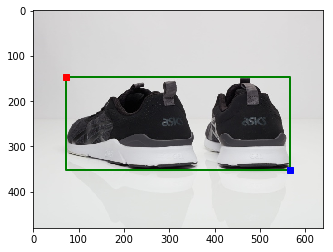

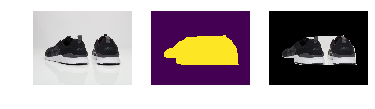

In [9]:
name_str,img,bb_boxes = id2imgname(train_df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)


plt.figure(figsize=(6,4))
plt.imshow(img)
plot_im_bbox(img,bb_boxes)
plt.show()

plot_im_mask(img,img_mask)

### Data generators

In [10]:
class DataGenerator(Sequence):

    def __init__(self, df, batch_size = BATCH_SIZE, aug = False, img_rows = 480, img_cols = 640,
                trans_range = 0, scale_range = 0):
            
        self.df = df
        self.aug = aug
        self.batch_size = batch_size
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.trans_range = trans_range
        self.scale_range = scale_range

    def __len__(self):
        return math.floor(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        batch_images = np.zeros((self.batch_size, img_rows, img_cols, 3))
        batch_masks = np.zeros((self.batch_size, img_rows, img_cols, 1))
        for batch_id, i_batch in enumerate(range(self.batch_size*idx, self.batch_size*(idx+1))):
            name_str,img,bb_boxes = id2imgname(self.df,i_batch,
                                                       size=(self.img_cols, self.img_rows),
                                                       augmentation=self.aug,
                                                       trans_range=self.trans_range,
                                                       scale_range=self.scale_range)
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[batch_id] = img
            batch_masks[batch_id] = img_mask/255
        return batch_images, batch_masks

### U-Net Architecture

Unet is popular architecture used for image segmentation. It was first used for performing segmentation on medical images. We implement the architecture as given in the UNet paper (	arXiv:1505.04597 ).

The network outputs a binary mask where the pixels representing the object should have values closer to 1 and others close to zero.

In [11]:
def get_unet():
    inputs = Input((img_rows, img_cols,3))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model    

In [12]:
unet = get_unet()
unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 640, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 240, 320, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

### Loss Function

For image segmentation Dice coefficient is a popular evaulation metric which is measures the similarity between the original binary mask representing the segmenting output and the mask predicted by the network, with a higher dice coefficient representing that the prediction is closer to the output. We use negative of the log of the dice coefficient as our loss function along with the binary cross entropy loss computed for each pixel.

In [13]:
def dice_coefficient(y_true, y_pred):
    num = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    den = tf.reduce_sum(y_true + y_pred, axis=-1)
    
    return num / (den + epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coefficient(y_true, y_pred) + epsilon())

def IOU_calc(y_true, y_pred):
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection) / (K.sum(y_true_f + y_pred_f))

Now that we have our model and loss function ready, we can compile it.

In [14]:
unet.compile(optimizer=Adam(lr=1e-4, decay=2e-6), 
              loss=loss, metrics=[IOU_calc])

checkpoint = ModelCheckpoint("uNet-{val_IOU_calc:.2f}.h5", monitor="val_IOU_calc", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)

reduce_lr = ReduceLROnPlateau(monitor="val_IOU_calc", factor=0.2, patience=3, min_lr=1e-7, verbose=1, mode="max")

We can initialize our data generators and start the training process.

In [15]:
training_gen = DataGenerator(train_df, batch_size=4, aug=True, img_rows = 480, img_cols = 640,
                trans_range = 50, scale_range = 50)

smooth = 1.

validation_gen = DataGenerator(test_df,16)

In [ ]:
unet.fit_generator(training_gen, epochs=200, validation_data=DataGenerator(test_df,16), callbacks=[checkpoint])

In [17]:
## Since the models will take a huge amount of time to train, you can download the trained weights from 
## this Google Drive folder into the directory
## https://drive.google.com/drive/folders/1rOVkxqHaCKjamji7c3XfdomvMbqksgU6?usp=sharing

WEIGHTS_FILE = "uNet-0.90.h5"

unet.load_weights(WEIGHTS_FILE)

Let's write some more functions to visualize and get bounding boxes from segmented masks.

In [18]:
def draw_bboxes(img, mask_pred):
    # Iterate through all detected cars
    arr = np.where(mask_pred[:,:,0]>240)[0]
    try:
        ymin = (np.min(arr[np.nonzero(arr)]))
    except ValueError:
        ymin = 0
    try:
        ymax = (np.max(arr[np.nonzero(arr)]))
    except ValueError:
        ymax = 0
    arr = np.where(mask_pred[:,:,0]>240)[1]
    try:
        xmin = (np.min(arr[np.nonzero(arr)]))
    except:
        xmin = 0
    try:
        xmax = (np.max(arr[np.nonzero(arr)]))
    except:
        xmax = 0
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,0,255), 3)
    return img

def test_new_img(img):
    img = cv2.resize(img,(img_cols, img_rows))
    img = np.reshape(img,(1,img_rows, img_cols,3))
    pred = unet.predict(img)
    return pred,img[0]

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    im_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    draw_img = draw_bboxes(img, im_pred)
    return draw_img

def get_bboxes(mask_pred):
    # Iterate through all detected cars
    arr = np.where(mask_pred[:,:,0]>240)[0]
    try:
        ymin = (np.min(arr[np.nonzero(arr)]))
    except ValueError:
        ymin = 0
    try:
        ymax = (np.max(arr[np.nonzero(arr)]))
    except ValueError:
        ymax = 0
    arr = np.where(mask_pred[:,:,0]>240)[1]
    try:
        xmin = (np.min(arr[np.nonzero(arr)]))
    except:
        xmin = 0
    try:
        xmax = (np.max(arr[np.nonzero(arr)]))
    except:
        xmax = 0
    return (xmin,xmax,ymin,ymax)

def bboxes(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    im_pred = np.array(255*pred[0],dtype=np.uint8)
    im_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    bboxes = get_bboxes(im_pred)
    return bboxes

Finally let's visualize some output from the network.

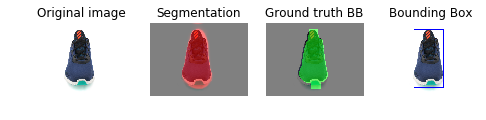

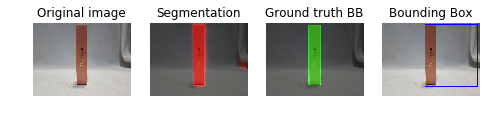

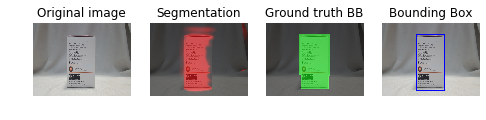

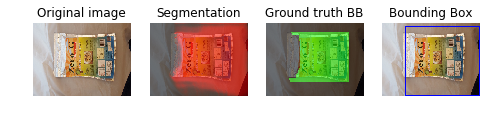

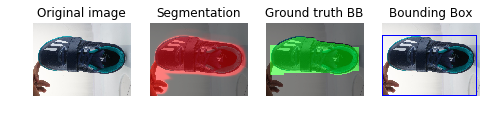

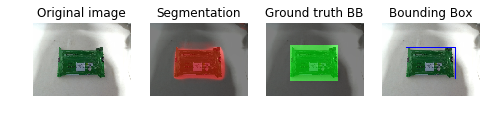

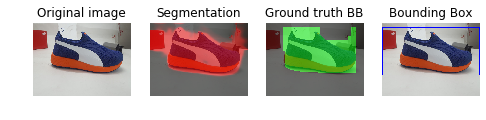

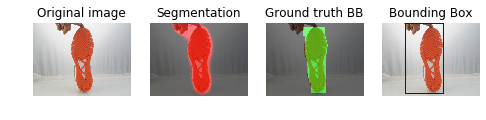

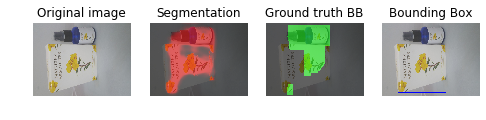

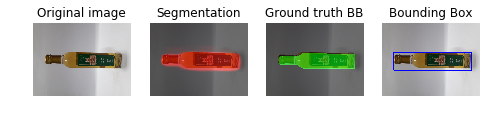

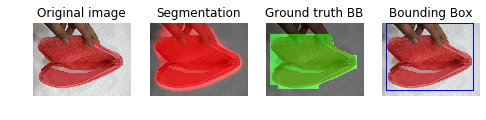

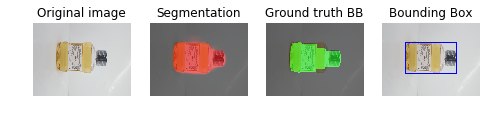

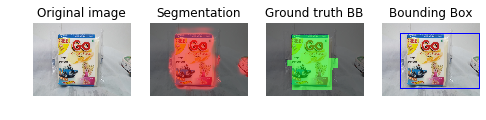

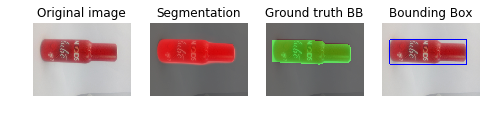

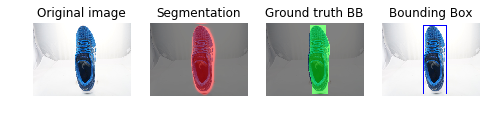

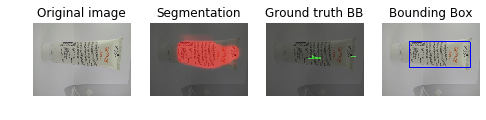

In [17]:
batch_img,batch_mask = validation_gen.__getitem__(2)
pred_all = unet.predict(batch_img)
np.shape(pred_all)

for i in range(len(pred_all)):
    
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    draw_img = get_BB_new_img(im)
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,4,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(img_pred)
    plt.title('Segmentation')
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(draw_img)
    plt.title('Bounding Box')
    plt.axis('off');
    plt.show()

And at last make predictions both on training and testing set like before.

In [19]:
test = pd.read_csv('test.csv')
test.head()

,image_name,x1,x2,y1,y2
0,1467891670691DSC_0582.png,NaN,NaN,NaN,NaN
1,1475151786691DSC00560.png,NaN,NaN,NaN,NaN
2,1480334114405_R2A3620.png,NaN,NaN,NaN,NaN
3,JPEG_20160712_161047_1000606860114.png,NaN,NaN,NaN,NaN
4,JPEG_20160403_174522_-1137349501.png,NaN,NaN,NaN,NaN


In [20]:
pd.options.mode.chained_assignment = None

for index,row in testing_df.iterrows():
    img = row['File_Path']
    im = cv2.imread(img)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    bbox = bboxes(im)
    test['x1'][index] = bbox[0]
    test['x2'][index] = bbox[1]
    test['y1'][index] = bbox[2]
    test['y2'][index] = bbox[3]
    
    if index%1000==0:
        print(index)
    
test.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000


,image_name,x1,x2,y1,y2
0,1467891670691DSC_0582.png,50.0,571.0,64.0,434.0
1,1475151786691DSC00560.png,241.0,409.0,134.0,415.0
2,1480334114405_R2A3620.png,209.0,424.0,108.0,361.0
3,JPEG_20160712_161047_1000606860114.png,93.0,502.0,2.0,411.0
4,JPEG_20160403_174522_-1137349501.png,135.0,547.0,39.0,372.0


In [21]:
test.to_csv('unet-prediction.csv', index=False)

In [22]:
train = pd.read_csv("training_set.csv")

for index, row in train_df.iterrows():
    img = row['File_Path']
    im = cv2.imread(img)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    bbox = bboxes(im)
    train['x1'][index] = bbox[0]
    train['x2'][index] = bbox[1]
    train['y1'][index] = bbox[2]
    train['y2'][index] = bbox[3]
    
    if index%1000==0:
        print(index)
        
train.to_csv('unet-training.csv', index=False)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
